In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sqlalchemy import create_engine
import statsmodels.api as sm
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)
engine.dispose()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [4]:
## Fill continuous variable null values with zero
for column in ['masvnrarea', 'lotfrontage', 'garagecars']:
    df[column] = df[column].fillna(0)
    
indexes = df[df.garageyrblt == 'None'].index
df.loc[indexes, ['garageyrblt']] = 1980
df['garageyrblt'] = pd.to_numeric(df['garageyrblt'])

## Fill all null values with 'none'
df = df.fillna('None')

In [5]:
df.corr().loc[:, 'saleprice'].sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
masvnrarea       0.472614
fireplaces       0.466929
bsmtfinsf1       0.386420
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
lotfrontage      0.209624
bedroomabvgr     0.168213
screenporch      0.111447
poolarea         0.092404
mosold           0.046432
threessnporch    0.044584
bsmtfinsf2      -0.011378
bsmthalfbath    -0.016844
miscval         -0.021190
id              -0.021917
lowqualfinsf    -0.025606
yrsold          -0.028923
overallcond     -0.077856
mssubclass      -0.084284
enclosedporch   -0.128578
kitchenabvgr    -0.135907
Name: saleprice, dtype: float64

In [6]:
## Taking the highest correlated features, adding in more features,
## and checking inter_feature correlation
df['ttl_sq_ft'] = df.totalbsmtsf + df.firstflrsf + df.secondflrsf
df['sqfXqual'] = df.ttl_sq_ft * df.overallqual
df = pd.concat([df, pd.get_dummies(df.mszoning, drop_first=True)], axis=1)

for column in df[['grlivarea', 'overallqual', 'garagecars', 'garagearea', 'totalbsmtsf',
                  'firstflrsf', 'fullbath', 'totrmsabvgrd', 'yearbuilt', 'yearremodadd',
                  'masvnrarea', 'fireplaces', 'bsmtfinsf1', 'ttl_sq_ft', 'sqfXqual', 'FV',
                  'RH', 'RL', 'RM']].corr().columns:
    print(column, (sum(df.corr().loc[:, column].sort_values(ascending=False)) / 19))

grlivarea 0.6546132546193291
overallqual 0.5701362343135468
garagecars 0.49090394225561135
garagearea 0.4925400162952116
totalbsmtsf 0.5064773470061505
firstflrsf 0.5095703886137515
fullbath 0.4920391957308662
totrmsabvgrd 0.5307557430291181
yearbuilt 0.33786785143173
yearremodadd 0.36430518308096593
masvnrarea 0.36714120567812186
fireplaces 0.38589604808281797
bsmtfinsf1 0.28840903757549596
ttl_sq_ft 0.6860958728015865
sqfXqual 0.6829660291475629
FV 0.06759233849619913
RH 0.005534220690041551
RL 0.15008552263547922
RM -0.19542939904589335


In [7]:
print(df.corr().loc[:, 'grlivarea'].sort_values(ascending=False))
print(df.corr().loc[:, 'ttl_sq_ft'].sort_values(ascending=False))        
print(df.corr().loc[:, 'sqfXqual'].sort_values(ascending=False))

grlivarea        1.000000
ttl_sq_ft        0.874373
totrmsabvgrd     0.825489
sqfXqual         0.819653
saleprice        0.708624
secondflrsf      0.687501
fullbath         0.630012
overallqual      0.593007
firstflrsf       0.566024
bedroomabvgr     0.521270
garagearea       0.468997
garagecars       0.467247
fireplaces       0.461679
totalbsmtsf      0.454868
halfbath         0.415772
masvnrarea       0.388052
openporchsf      0.330224
yearremodadd     0.287389
lotarea          0.263116
wooddecksf       0.247433
bsmtunfsf        0.240257
lotfrontage      0.220347
bsmtfinsf1       0.208171
yearbuilt        0.199010
poolarea         0.170205
lowqualfinsf     0.134683
RL               0.132936
screenporch      0.101510
kitchenabvgr     0.100063
mssubclass       0.074853
mosold           0.050240
bsmtfullbath     0.034836
FV               0.024275
threessnporch    0.020643
enclosedporch    0.009113
id               0.008273
RH              -0.001070
miscval         -0.002416
bsmtfinsf2  

ttl_sq_ft, overallqual, grlivarea will be taken out as three highest correlated features with sfXqual.

In [8]:
df2 = df[['saleprice', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf', 'fullbath',
          'totrmsabvgrd', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'fireplaces',
          'bsmtfinsf1', 'sqfXqual', 'FV', 'RH', 'RL', 'RM']]

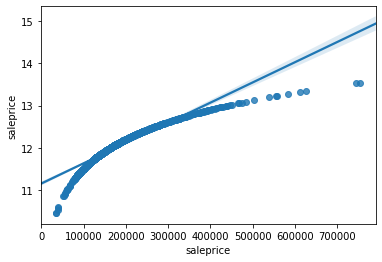

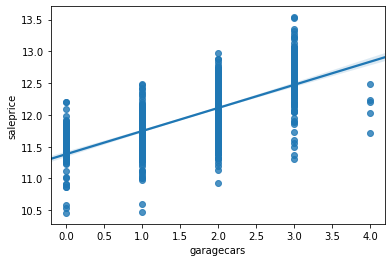

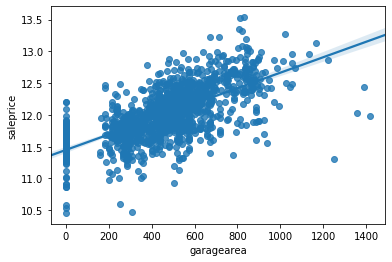

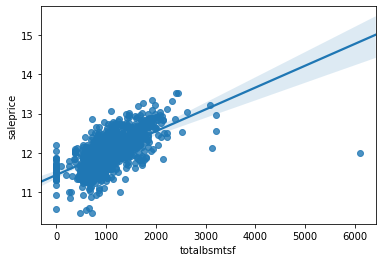

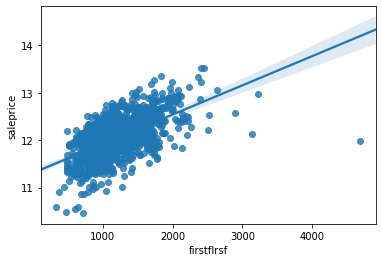

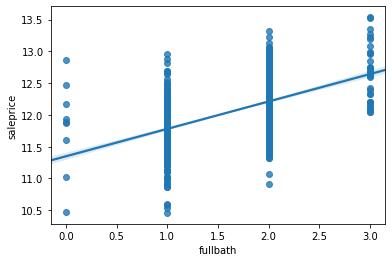

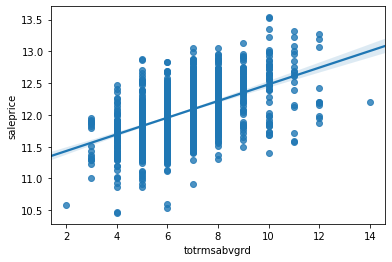

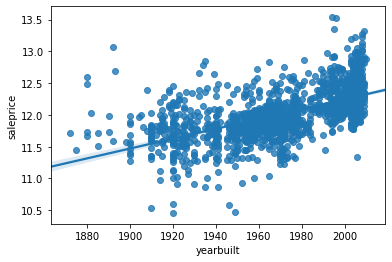

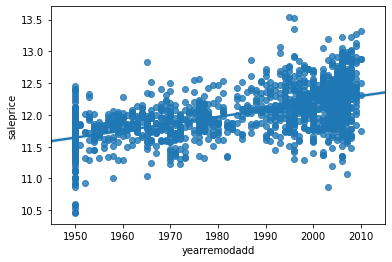

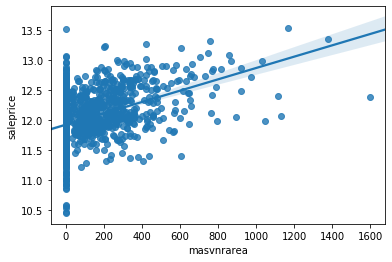

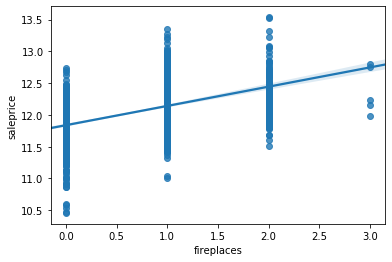

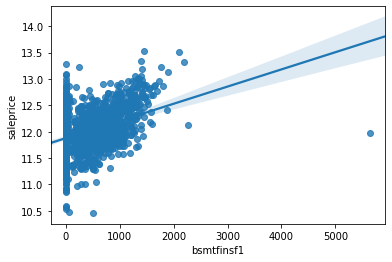

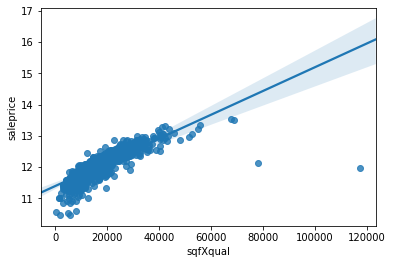

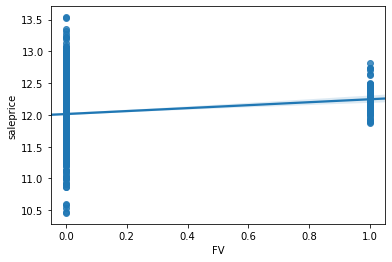

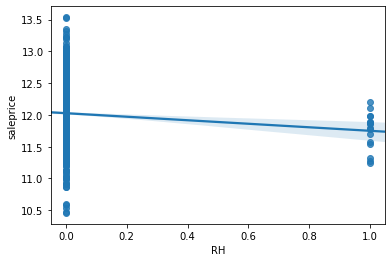

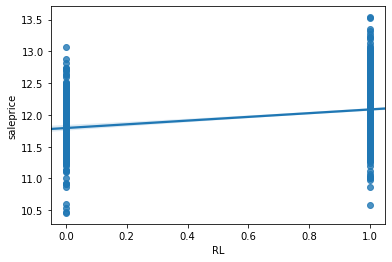

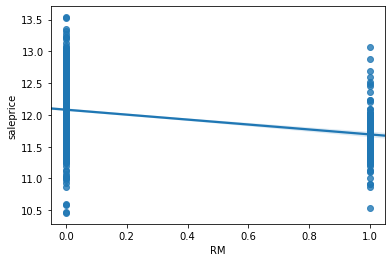

In [9]:
## Checking for outliers and distributions

for column in df2:
    sns.regplot(x = df2[column], y = np.log1p(df2.saleprice))
    plt.show()

In [10]:
## winsorizing

df2.sqfXqual = winsorize(df2.sqfXqual, limits=[0.01, 0.01])
df2.bsmtfinsf1 = winsorize(df2.bsmtfinsf1, limits=[0.01, 0.01])
df2.masvnrarea = winsorize(df2.masvnrarea, limits=[0.01, 0.01])
df2.firstflrsf = winsorize(df2.firstflrsf, limits=[0.01, 0.01])

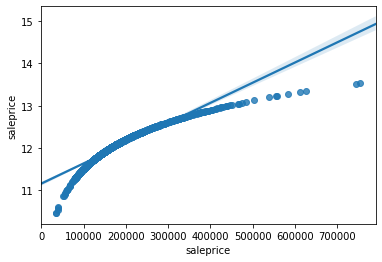

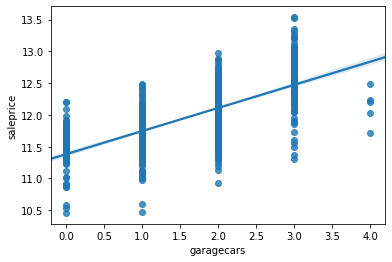

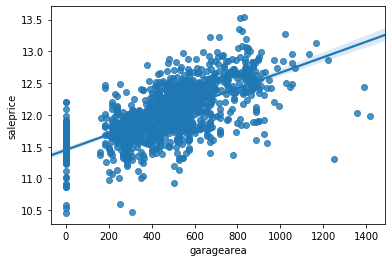

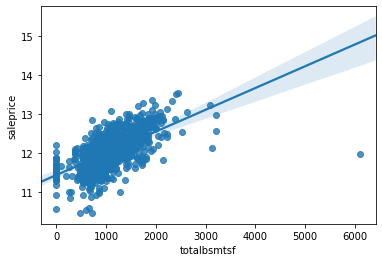

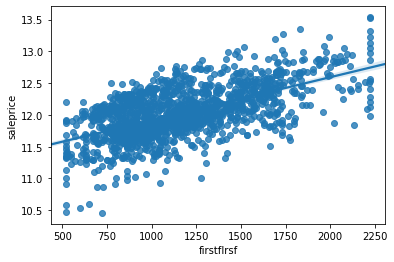

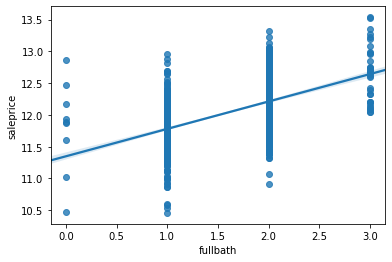

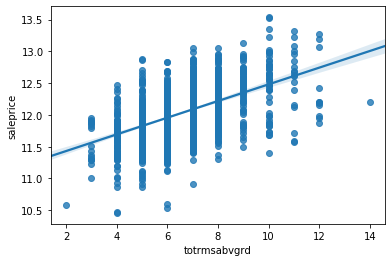

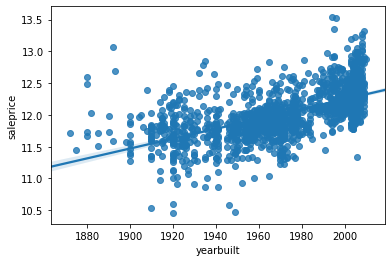

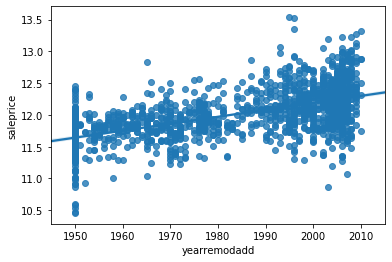

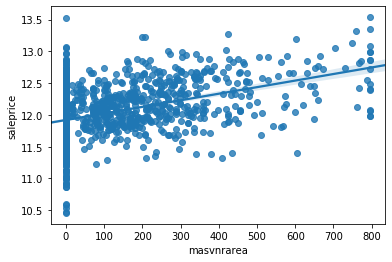

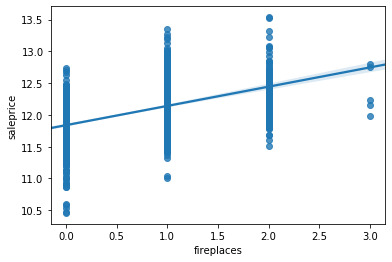

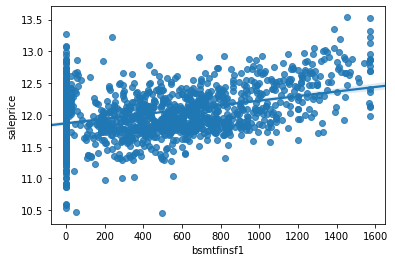

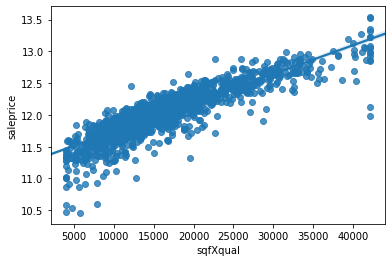

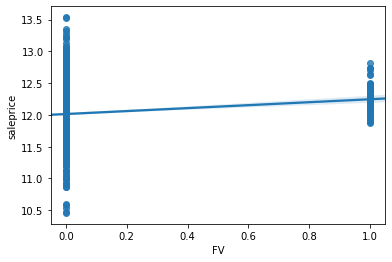

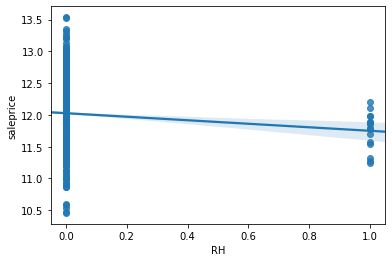

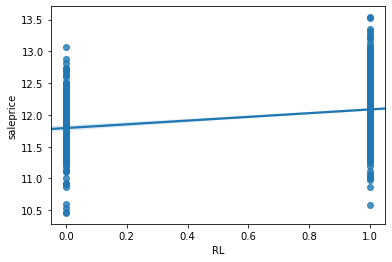

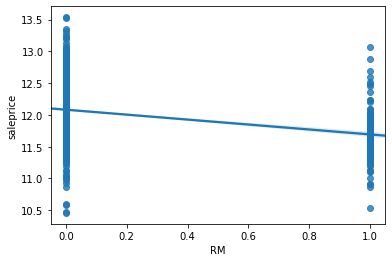

In [11]:
for column in df2:
    sns.regplot(x = df2[column], y = np.log1p(df2.saleprice))
    plt.show()

In [12]:
Y = np.log1p(df2.saleprice)
X = df2.drop(columns = ['saleprice'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .02, random_state = 390)

In [13]:
## Basic OLS model

lrm = LinearRegression()
lrm.fit(X_train, Y_train)

Y_pred_train = lrm.predict(X_train)
Y_pred_test = lrm.predict(X_test)

print('R-squared train: {} \nR-squared test: {}'.format(
    lrm.score(X_train, Y_train), lrm.score(X_test, Y_test)))
print('MAE: {}'.format(mean_absolute_error(Y_test, Y_pred_test)))
print('MSE: {}'.format(mse(Y_test, Y_pred_test)))
print('RMSE: {}'.format(rmse(Y_test, Y_pred_test)))
print('MAPE: {}'.format(((Y_test - Y_pred_test) / Y_test).abs().mean()))

R-squared train: 0.8722969769830524 
R-squared test: 0.9095718556446106
MAE: 0.09285626313114073
MSE: 0.01839961171606512
RMSE: 0.1356451684213821
MAPE: 0.007914260971436143


In [14]:
## Ridge with example's alpha

ridge = Ridge(alpha=10**37)
ridge.fit(X_train, Y_train)

Y_pred_train = lrm.predict(X_train)
Y_pred_test = lrm.predict(X_test)

print('R-squared train: {} \n R-squared test: {}'.format(
    ridge.score(X_train, Y_train), ridge.score(X_test, Y_test)))
print('MAE: {}'.format(mean_absolute_error(Y_test, Y_pred_test)))
print('MSE: {}'.format(mse(Y_test, Y_pred_test)))
print('RMSE: {}'.format(rmse(Y_test, Y_pred_test)))
print('MAPE: {}'.format(((Y_test - Y_pred_test) / Y_test).abs().mean()))

R-squared train: 0.0 
 R-squared test: -0.002230960694857176
MAE: 0.09285626313114073
MSE: 0.01839961171606512
RMSE: 0.1356451684213821
MAPE: 0.007914260971436143


In [15]:
## Earlier ridge model did not perform well, so we reduce the model's smoothing of the data

ridge = Ridge(alpha=10**10)
ridge.fit(X_train, Y_train)

Y_pred_train = lrm.predict(X_train)
Y_pred_test = lrm.predict(X_test)

print('R-squared train: {} \n R-squared test: {}'.format(
    ridge.score(X_train, Y_train), ridge.score(X_test, Y_test)))
print('MAE: {}'.format(mean_absolute_error(Y_test, Y_pred_test)))
print('MSE: {}'.format(mse(Y_test, Y_pred_test)))
print('RMSE: {}'.format(rmse(Y_test, Y_pred_test)))
print('MAPE: {}'.format(((Y_test - Y_pred_test) / Y_test).abs().mean()))

R-squared train: 0.7696885934571962 
 R-squared test: 0.7061756773012204
MAE: 0.09285626313114073
MSE: 0.01839961171606512
RMSE: 0.1356451684213821
MAPE: 0.007914260971436143


In [16]:
ridge = Ridge(alpha=10**37)
clf = GridSearchCV(ridge, {'alpha':range(100)}, cv=5)
clf.fit(X_train, Y_train)
clf.best_params_

{'alpha': 0}

In [17]:
## Ridge with 0 alpha. OLS is the better route here, then

ridge = Ridge(alpha=0)
ridge.fit(X_train, Y_train)

Y_pred_train = lrm.predict(X_train)
Y_pred_test = lrm.predict(X_test)

print('R-squared train: {} \n R-squared test: {}'.format(
    ridge.score(X_train, Y_train), ridge.score(X_test, Y_test)))
print('MAE: {}'.format(mean_absolute_error(Y_test, Y_pred_test)))
print('MSE: {}'.format(mse(Y_test, Y_pred_test)))
print('RMSE: {}'.format(rmse(Y_test, Y_pred_test)))
print('MAPE: {}'.format(((Y_test - Y_pred_test) / Y_test).abs().mean()))

R-squared train: 0.8722969769830524 
 R-squared test: 0.9095718556446133
MAE: 0.09285626313114073
MSE: 0.01839961171606512
RMSE: 0.1356451684213821
MAPE: 0.007914260971436143


In [18]:
## Lasso model using what I believe was the alpha from the example with dismal performance.
## I tried using other alphas to little avail, but at least MAPE is low.

lasso = Lasso(alpha=10**25)
lasso.fit(X_train, Y_train)

Y_pred_train = lasso.predict(X_train)
Y_pred_test = lasso.predict(X_test)

print('R-squared train: {} \n R-squared test: {}'.format(
    lasso.score(X_train, Y_train), lasso.score(X_test, Y_test)))
print('MAE: {}'.format(mean_absolute_error(Y_test, Y_pred_test)))
print('MSE: {}'.format(mse(Y_test, Y_pred_test)))
print('RMSE: {}'.format(rmse(Y_test, Y_pred_test)))
print('MAPE: {}'.format(((Y_test - Y_pred_test) / Y_test).abs().mean()))

R-squared train: 0.0 
 R-squared test: -0.002230960694857176
MAE: 0.33582277665744464
MSE: 0.20392611899820828
RMSE: 0.45158179657533615
MAPE: 0.028320178258867325


In [19]:
## This was the result of some experimentation with the alpha and ratio, which led to little again.
## OLS seems to be a better fit than the other three.

elastic = ElasticNet(alpha=10**10, l1_ratio=0.8)
elastic.fit(X_train, Y_train)

Y_pred_train = elastic.predict(X_train)
Y_pred_test = elastic.predict(X_test)

print('R-squared train: {} \n R-squared test: {}'.format(
    elastic.score(X_train, Y_train), elastic.score(X_test, Y_test)))
print('MAE: {}'.format(mean_absolute_error(Y_test, Y_pred_test)))
print('MSE: {}'.format(mse(Y_test, Y_pred_test)))
print('RMSE: {}'.format(rmse(Y_test, Y_pred_test)))
print('MAPE: {}'.format(((Y_test - Y_pred_test) / Y_test).abs().mean()))

R-squared train: 0.0 
 R-squared test: -0.002230960694857176
MAE: 0.33582277665744464
MSE: 0.20392611899820828
RMSE: 0.45158179657533615
MAPE: 0.028320178258867325


The data added to the dataframe below is US GDP for every year and the 30 year fixed mortgage rate in the US for every year. Both are from FRED.

In [20]:
df_gdp = pd.read_csv('data/GDP.csv')
df_gdp_jan = df_gdp[df_gdp.DATE.str.contains('-01-') == True ]
df_gdp_jan.DATE = df_gdp.DATE.str[:4]

In [21]:
years = df.yrsold.unique()
df_gdp_jan.DATE = df_gdp_jan.DATE.astype(int)
df['gdp'] = 0
for year in years:
    indexes = df[df.yrsold == year].gdp.index
    gdp = df_gdp_jan[df_gdp_jan.DATE == year].GDP.values
    for index in indexes:
        df.loc[index, ['gdp']] = gdp

In [22]:
df_mor = pd.read_csv('data/MORTGAGE30US.csv')
df_mor_april = df_mor[df_mor.DATE.str.contains('-04-') == True ]
df_mor_april.DATE = df_mor_april.DATE.str[:4]

In [23]:
df_mor_april.DATE = df_mor_april.DATE.astype(int)
df['mor'] = 0
for year in years:
    indexes = df[df.yrsold == year].mor.index
    mor = df_mor_april[df_mor_april.DATE == year].MORTGAGE30US.values.mean()
    for index in indexes:
        df.loc[index, ['mor']] = mor

Integrating the new variables for mortgage rates and gdp at the time of selling:

In [24]:
df2 = df[['yearbuilt', 'yearremodadd', 'bsmtfinsf1', 'fireplaces', 'garagecars',
          'wooddecksf', 'secondflrsf', 'FV', 'RH', 'RL', 'RM', 'gdp', 'mor',
          'saleprice', 'ttl_sq_ft', 'sqfXqual']]

Y = np.log1p(df2.saleprice)
X = df2.drop(columns = ['saleprice'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .02, random_state = 390)

In [25]:
lrm = LinearRegression()
lrm.fit(X_train, Y_train)

Y_pred_train = lrm.predict(X_train)
Y_pred_test = lrm.predict(X_test)

print('R-squared train: {} \nR-squared test: {}'.format(
    lrm.score(X_train, Y_train), lrm.score(X_test, Y_test)))
print('MAE: {}'.format(mean_absolute_error(Y_test, Y_pred_test)))
print('MSE: {}'.format(mse(Y_test, Y_pred_test)))
print('RMSE: {}'.format(rmse(Y_test, Y_pred_test)))
print('MAPE: {}'.format(((Y_test - Y_pred_test) / Y_test).abs().mean()))

R-squared train: 0.826206886177197 
R-squared test: 0.9074365838475509
MAE: 0.09143413466307872
MSE: 0.018834080124703004
RMSE: 0.13723731316483503
MAPE: 0.0078047168616098605


In [26]:
X = sm.add_constant(X)
lrm = sm.OLS(Y, X).fit()
lrm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     465.0
Date:                Wed, 28 Aug 2019   Prob (F-statistic):               0.00
Time:                        23:06:57   Log-Likelihood:                 555.69
No. Observations:                1460   AIC:                            -1079.
Df Residuals:                    1444   BIC:                            -994.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.7389      0.591      2.941      0.003       0.579       2.899
yearbuilt        0.0011      0.000      4.978      0.000       0.001       0.002
yearremodadd     0.0033      0.000     12.006      0.000       0.003       0.004
bsmtfinsf1    4.318e-05   1.13e-05      3.821      0.000     2.1e-05    6.54e-05
fireplaces       0.0761      0.008      9.608      0.000       0.061       0.092
garagecars       0.1070      0.008     13.623      0.000       0.092       0.122
wooddecksf       0.0001   3.72e-05      3.870      0.000     7.1e-05       0.000
secondflrsf   8.005e-05   1.15e-05      6.934      0.000    5.74e-05       0.000
FV               0.5382      0.058      9.237      0.000       0.424       0.653
RH               0.4608      0.067      6.844      0.000       0.329       0.593
RL               0.5027      0.054      9.365      0.000       0.397       0.608
RM               0.3776      0.054      6.985      0.000       0.272       0.484
gdp            1.44e-05   1.44e-05      0.998      0.318   -1.39e-05    4.27e-05
mor              0.0207      0.009      2.389      0.017       0.004       0.038
ttl_sq_ft     5.718e-05   1.66e-05      3.438      0.001    2.46e-05    8.98e-05
sqfXqual      1.514e-05   1.66e-06      9.133      0.000    1.19e-05    1.84e-05
==============================================================================
Omnibus:                     1418.623   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           212261.409
Skew:                          -4.112   Prob(JB):                         0.00
Kurtosis:                      61.494   Cond. No.                     3.14e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.14e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Integrating the new variables really doesn't do much. The errors and r squared improved, but only ever so slightly, and the variables are insignificant anyways.

## Conclusion
After some data cleaning and winsoriaztion, we found 19 features that predicted sale price rather admirably well. We proceeded to test a standard linear model, a ridge model, a lasso model, and an elastic net model. The latter models were uniformly worse than the standard linear model with estimated hyperparameters. Hyperparameters were adjusted on the latter models to optimize them, and that showed that the only suitable hyperparameters made them equivalent to the standard linear model, confirming the standard model's superiority in this case.